### Do the following steps in bash to get CellTag Matrix Expression
1. Download BAM file for samples at day 15
2. Extract celltag reads from BAM file
3. Parse reads to extract required information
I've also added the extracted file in the repository.

In [11]:
# #bash
# wget https://sra-pub-src-1.s3.amazonaws.com/SRR7347033/hf1.d15.possorted_genome_bam.bam.1

# samtools view hf1.d15.possorted_genome_bam.bam | grep -P 'GGT[ACTG]{8}GAATTC' > v1.celltag.reads.out
# samtools view hf1.d15.possorted_genome_bam.bam | grep -P 'GTGATG[ACTG]{8}GAATTC' > v2.celltag.reads.out
# samtools view hf1.d15.possorted_genome_bam.bam | grep -P 'TGTACG[ACTG]{8}GAATTC' > v3.celltag.reads.out

# ./scripts/celltag.parse.reads.10x.sh -v tagregex="CCGGT([ACTG]{8})GAATTC" v1.celltag.reads.out > v1.celltag.parsed.tsv
# ./scripts/celltag.parse.reads.10x.sh -v tagregex="GTGATG([ACTG]{8})GAATTC" v2.celltag.reads.out > v2.celltag.parsed.tsv
# ./scripts/celltag.parse.reads.10x.sh -v tagregex="TGTACG([ACTG]{8})GAATTC" v3.celltag.reads.out > v3.celltag.parsed.tsv

# Rscript ./scripts/matrix.count.celltags.R ./cell.barcodes/hf1.d15.barcodes.tsv v1.celltag.parsed.tsv hf1.d15.v1
# Rscript ./scripts/matrix.count.celltags.R ./cell.barcodes/hf1.d15.barcodes.tsv v2.celltag.parsed.tsv hf1.d15.v2
# Rscript ./scripts/matrix.count.celltags.R ./cell.barcodes/hf1.d15.barcodes.tsv v3.celltag.parsed.tsv hf1.d15.v3

In [1]:
import pyreadr #!pip install pyradr
import numpy as np
import pandas as pd
import celltagging_utils as ct
import matplotlib.pyplot as plt
import seaborn as sns
from pyvis.network import Network
import importlib
import networkx as nx
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

### Read data from celltag matrix

In [2]:
mef = pyreadr.read_r("./celltag_matrix/hf1.d15.v1.celltag.matrix.Rds")[None]
d3 = pyreadr.read_r("./celltag_matrix/hf1.d15.v2.celltag.matrix.Rds")[None]
d13 = pyreadr.read_r("./celltag_matrix/hf1.d15.v3.celltag.matrix.Rds")[None]

mef.set_index('Cell.BC',inplace=True)
d3.set_index('Cell.BC',inplace=True)
d13.set_index('Cell.BC',inplace=True)

mef.shape, d3.shape, d13.shape

((3812, 6319), (3812, 8246), (3812, 4630))

In [3]:
mef.head()

,AAAAAAGA,AAAAAAGC,AAAAAATA,AAAAACTC,AAAAACTG,AAAAAGAC,AAAAAGCC,AAAAAGCG,AAAAAGGG,AAAACTAA,...,TTTTTCGG,TTTTTCTA,TTTTTGAT,TTTTTGCA,TTTTTGTT,TTTTTTAT,TTTTTTCC,TTTTTTCT,TTTTTTGG,TTTTTTTT
Cell.BC,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGTATGACA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGCAGCCTATA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGGTAAGTAGT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGTCACAACGT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGTCCGCGCAA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Get stats

In [4]:
ct.get_stats(mef)

,Cell_UMI_Counts,CellTags_per_Cell,CellTag_UMI_Counts,Cells_per_CellTag
count,3812.000000,3812.000000,6319.000000,6319.000000
mean,54.328437,5.917629,32.774173,3.569869
std,96.041066,6.887981,379.364072,16.430824
min,0.000000,0.000000,1.000000,1.000000
25%,2.000000,2.000000,1.000000,1.000000
50%,20.000000,4.000000,1.000000,1.000000
75%,64.000000,8.000000,4.000000,2.000000
max,1549.000000,84.000000,20226.000000,569.000000


### Binarize data
Convert the CellTag UMI count matrices into binary matrices and any Cell Barcode/CellTag pair with a UMI count less than a cutoff will be disregarded

In [5]:
mef_bin = ct.single_cell_data_binarization(mef, 2)
d3_bin = ct.single_cell_data_binarization(d3, 2)
d13_bin = ct.single_cell_data_binarization(d13, 2)

### Filter Tags (White list)
‘Whitelisting’ is performed to remove PCR and sequencing artifacts that are not corrected in the previous step. This whitelisting consists of filtering out CellTags that are not detected from sequencing of the original complex CellTag library.

In [6]:
mef_filt = ct.single_cell_data_whitelist(mef_bin, "./whitelist/V1.CellTag.Whitelist.csv")
d3_filt = ct.single_cell_data_whitelist(d3_bin, "./whitelist/V2.CellTag.Whitelist.csv")
d13_filt = ct.single_cell_data_whitelist(d13_bin, "./whitelist/V3.CellTag.Whitelist.csv")
print(mef_filt.shape, d3_filt.shape, d13_filt.shape)

(3812, 3256) (3812, 2537) (3812, 1981)


### Filter Cells
Cells with >20 CellTags (likely to correspond to cell multiplets) and less than two unique CellTags per cell are filtered out.

In [7]:
mef_filt = ct.metric_based_filtering(mef_filt, 20, "less")
d3_filt = ct.metric_based_filtering(d3_filt, 20, "less")
d13_filt = ct.metric_based_filtering(d13_filt, 20, "less")

mef_filt = ct.metric_based_filtering(mef_filt, 2, "greater")
d3_filt = ct.metric_based_filtering(d3_filt, 2, "greater")
d13_filt = ct.metric_based_filtering(d13_filt, 2, "greater")
print(mef_filt.shape, d3_filt.shape, d13_filt.shape)

(1852, 3256) (1733, 2537) (717, 1981)


### Jaccard Analysis (Cell-Cell)
Clone calling is performed where Jaccard coefficient scores were calculated to assess the similarity of CellTag expression signatures in all cells in a pairwise manner, thereby identifying clonally related cells.

In [8]:
mef_sim = ct.jaccard_analysis(mef_filt, id='mef')
d3_sim = ct.jaccard_analysis(d3_filt, id='d3')
d13_sim = ct.jaccard_analysis(d13_filt, id='d13')

Calculating Jaccard Similarities:   0%|          | 0/1852 [00:00<?, ?it/s]

Calculating Jaccard Similarities:   0%|          | 0/1733 [00:00<?, ?it/s]

Calculating Jaccard Similarities:   0%|          | 0/717 [00:00<?, ?it/s]

### Clone Calling
Cells with a given threshold for similarity (here 0.7) will be get the same clone index. Celones with one cell will be disregarded.

In [9]:
mef_clones, mef_clone_size = ct.clone_calling(mef_sim, "./hf1.d15.v1.clones.csv", 0.7)
d3_clones, d3_clone_size = ct.clone_calling(d3_sim, "./hf1.d15.v2.clones.csv", 0.7)
d13_clones, d13_clone_size = ct.clone_calling(d13_sim, "./hf1.d15.v13.clones.csv", 0.7)
print(mef_clones.head())
print(mef_clone_size.head())

   clone_id      cell_barcode
0         1  CTCATTATCGCGGATC
1         1  CAGATCACAACTTGAC
2         1  GTCTCGTGTTCCATGA
3         1  CGTCAGGCAAGCGAGT
4         1  CGGACGTTCACTCCTG
   Clone_ID  Frequency
0         2        228
1         4        202
2        16         65
3        13         56
4         8         53


### Lineage and Visualization

In [192]:
mef_clones.rename(columns={mef_clones.columns[0]: "CellTagV1"}, inplace=True)
d3_clones.rename(columns={d3_clones.columns[0]: "CellTagV2"}, inplace=True)
d13_clones.rename(columns={d13_clones.columns[0]: "CellTagV3"}, inplace=True)

In [193]:
clone_cells = pd.concat([mef_clones.cell_barcode, d3_clones.cell_barcode, d13_clones.cell_barcode]).unique()
celltag_data = pd.DataFrame(index=clone_cells, columns=["CellTagV1", "CellTagV2", "CellTagV3"])

In [194]:
celltag_data.loc[mef_clones['cell_barcode'], "CellTagV1"] = mef_clones["CellTagV1"].values
celltag_data.loc[d3_clones['cell_barcode'], "CellTagV2"] = d3_clones["CellTagV2"].values
celltag_data.loc[d13_clones['cell_barcode'], "CellTagV3"] = d13_clones["CellTagV3"].values
celltag_data.index = celltag_data.index.map(lambda x: x + "-1")
celltag_data

,CellTagV1,CellTagV2,CellTagV3
CTCATTATCGCGGATC-1,1,NaN,NaN
CAGATCACAACTTGAC-1,1,NaN,NaN
GTCTCGTGTTCCATGA-1,1,NaN,NaN
CGTCAGGCAAGCGAGT-1,1,NaN,NaN
CGGACGTTCACTCCTG-1,1,NaN,NaN
...,...,...,...
GGAGCAAGTTACCGAT-1,NaN,NaN,45
TGACAACCAAAGGAAG-1,NaN,NaN,48
TCTCATAGTCCGTTAA-1,NaN,NaN,48
TGCGCAGAGATATGCA-1,NaN,NaN,50


### Create Linklist of Relation between Cells and CellTags
- CellTagV1 Clones: 166 (1402 Cells)
- CellTagV2 Clones: 197 (1174 Cells)
- CellTagV3 Clones: 50 (100 Cells)
- Cells in 1 Clone: 1268
- Cells in 2 Clones: 659 (1318 Nodes)
- Cells in 3 Clones: 30 (90 Nodes)
- Unique Cells: 1957
- **Nodes Count: 3089** -> 413 Clones + 2676 Cells -> (166+197+50) + (1268+1318+90)

(1268 + 1318 + 90) = (1402 + 1174 + 100) = 2676

In [195]:
link_list = ct.convert_cell_tag_matrix_to_link_list(celltag_data)
all_nodes = ct.get_nodes_from_link_list(link_list)

Preprocessing data..
Cells that have CellTagV1: 1402
Cells that have CellTagV2: 1174
Cells that have CellTagV3: 100
find connection between [celltag -> cells]...
find hidden links [CellTagV2 -> CellTagV3], or [CellTagV1 -> CellTagV3]...
find hidden links [CellTagV1 -> CellTagV2]...
finished


In [197]:
ref_nodes = ["CellTagV1_95"]
sub_links, sub_nodes = ct.get_subnet(ref_nodes, link_list, all_nodes)
print("Links:", sub_links.shape[0], "\nNodes:",sub_nodes.shape[0])

Links: 25 
Nodes: 15


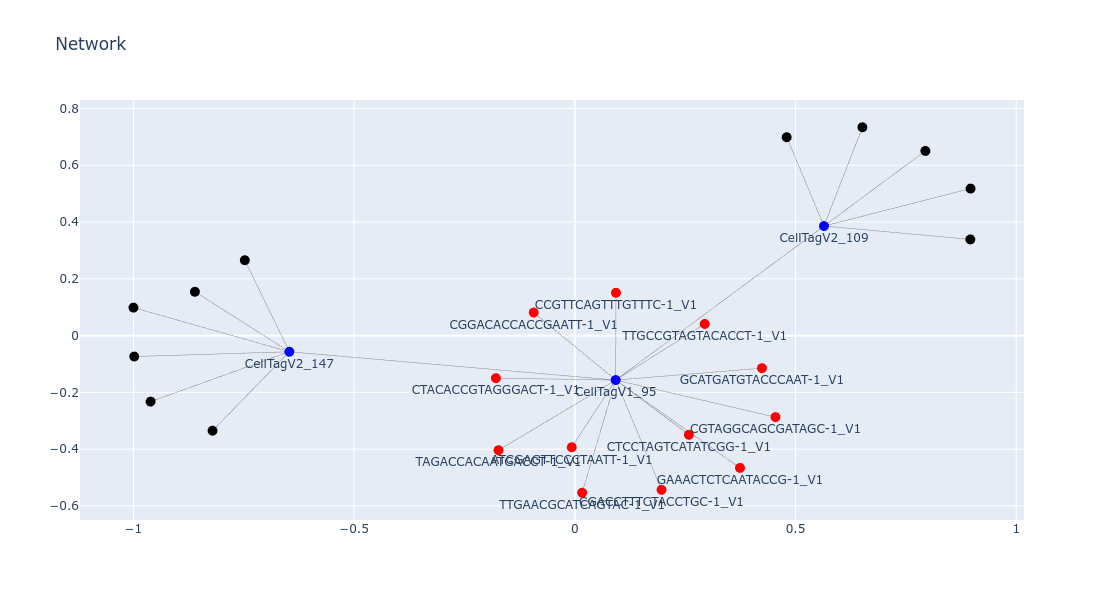

In [198]:
G = nx.Graph()
G.add_nodes_from(sub_nodes['nodes'])
edges = [(row['source'], row['target']) for index, row in sub_links.iterrows()]
G.add_edges_from(edges)

# Define the layout of the graph
layout = go.Layout(
    title="Network",
    showlegend=False,
    hovermode='closest',
    width=800,
    height=600
)

plotly_graph = nx.spring_layout(G)  

# Create node positions
node_x = []
node_y = []
for node in plotly_graph:
    x, y = plotly_graph[node]
    node_x.append(x)
    node_y.append(y)

color_mapping = {
    'cell': 'red',
    'clone': 'blue',
}
node_colors = [color_mapping.get(category, 'gray') for category in sub_nodes['type']]

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',  # Add 'text' mode to display labels
    #"hoverinfo='text',
    text=sub_nodes['nodes'],  # Set the labels to node names
    textposition='bottom center',  # Adjust the label position
    marker=dict(
        showscale=False,
        color=node_colors,
        size=10
    )
)

edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = plotly_graph[edge[0]]
    x1, y1 = plotly_graph[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

fig = go.Figure(data=[edge_trace, node_trace], layout=layout)

iplot(fig)

In [199]:
celltag_data[celltag_data['CellTagV1']==95]

,CellTagV1,CellTagV2,CellTagV3
CCGTTCAGTTTGTTTC-1,95,147,26
CTCCTAGTCATATCGG-1,95,e,e
CGGACACCACCGAATT-1,95,109,e
CTACACCGTAGGGACT-1,95,109,e
CGTAGGCAGCGATAGC-1,95,147,e
GAAACTCTCAATACCG-1,95,109,e
GCATGATGTACCCAAT-1,95,e,e
TTGCCGTAGTACACCT-1,95,109,e
ATCGAGTTCCCTAATT-1,95,109,e
CGACCTTTCTACCTGC-1,95,147,26
